# Predicting Blue-Chip Company Financial Trajectory

### COMS W4995 – Applied Machine Learning

#### **Group 24**: Yu-Heng Chi, Param Sejpal, Jessica Villanueva, Yihan Yang, Zhiyi Zhang

#### **UNI IDs**: yc4548, pns2129, jss2326, yy3528, zz3274

---


### Objective
Our objective is to measure a company’s financial health trajectory indicated by the equity value of the company. This means predicting the annual market capitalization ("Market Cap") using annual data (e.g., year-end market cap for 2025). The financial metrics we used are from a 2024 dataset for Fortune 1000 companies, and additional financial metrics we worked with are from 10-K reports found on the SEC database (More information on data sources is in the README.md and project deliverables).

In this project, we will:

1. **Regression**: Predicting the annual market cap using annual data (e.g., year-end market cap for 2025). The financial metrics we use include revenue, profits, EBITDA, and other key indicators.
2. **Classification**: Classifying companies as **growth** or **non-growth** based on financial health metrics like EBITDA margins.

In [828]:
# Imports

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer


In [829]:
# Load data
initial_df = pd.read_csv('data/FinancialData.csv')
initial_df.head()

,Company,Sector,Industry,Profitable,Number_of_employees,MarketCap_March28_M,Revenues_M,RevenuePercentChange,Profits_M,ProfitsPercentChange,Assets_M,CompanyType,MarketCap_Updated_M,EBITDA,EBITDA_Margin
0,Walmart,Retailing,General Merchandisers,yes,2100000,484852.8,648125.0,6.0,15511.0,32.8,252399.0,Public,559911.0,3.638400e+10,56137.319190
1,Amazon,Retailing,Internet Services and Retailing,yes,1525000,1873675.8,574785.0,11.8,30425.0,NaN,527854.0,Public,2005565.0,1.134840e+11,197437.302644
2,Apple,Technology,"Computers, Office Equipment",yes,161000,2647973.8,383285.0,-2.8,96995.0,-2.8,352583.0,Public,3594309.0,1.346610e+11,351333.863835
3,UnitedHealth Group,Health Care,Health Care: Insurance and Managed Care,yes,440000,456080.8,371622.0,14.6,22381.0,11.2,273720.0,Public,474339.0,2.790400e+10,75087.050820
4,Berkshire Hathaway,Financials,Insurance: Property and Casualty (Stock),yes,396500,908919.7,364482.0,20.7,96223.0,NaN,1069978.0,Public,937028.0,NaN,0.000000


# I. Preparing the data
We will analyze and visualize `FinancialData.csv`, inlcuding handling missing data, investigating and handling class imbalance, post-processing, and other data preparation methods.


Our **target** variable that we are aiming to predict is Market Cap. We have the following features that are relevant for predicting this variable:

1. Metrics describing *revenue* (e.g., Revenues_M, RevenuePercentChange).
2. Metrics describing *profit and earnings* (e.g., Profits_M, ProfitsPercentChange, EBITDA).
3. Metrics describing *company* assets (e.g., Assets_M).

*Note*: As we can already tell, some metrics may introduce multicollinearity into the dataset. 

The other features (Worlds_Most_Admired_Companies, Best_Companies_to_Work_For, and other features) are generally irrelevant for predicting financial metrics like Market Cap. In `generate.py`, we removed these irrelevant columsns to create a dataset with only relevant features. Next, we will handle missing values and correlated features.

### **Part 1: Data analaysis, visualization, and summarization**


In [830]:
initial_df = initial_df.dropna(subset=['MarketCap_March28_M'])
initial_df = initial_df.drop(columns=['Company'])

**1.1 Create bar plot comparing Market Cap by Industry and Company Type**

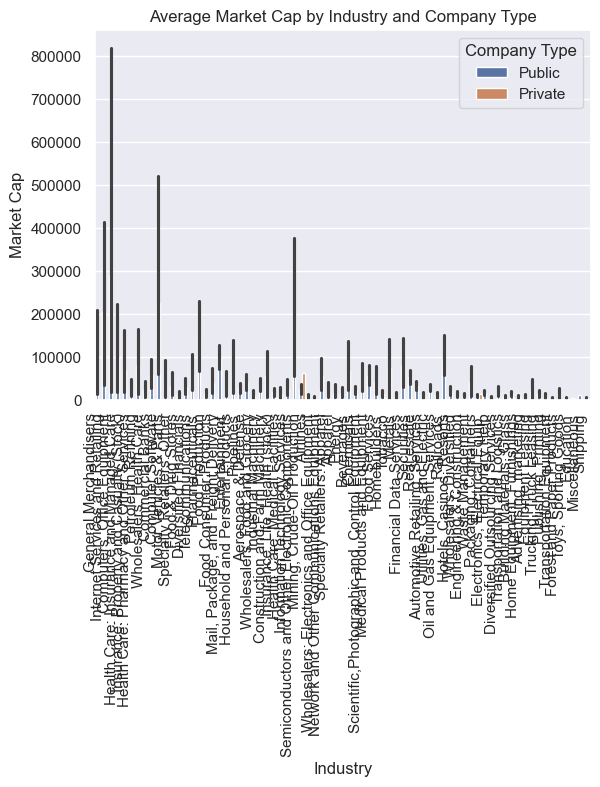

In [831]:
sns.barplot(initial_df, x="Industry", y="MarketCap_March28_M", hue="CompanyType")

# Labels
plt.title(f"Average Market Cap by Industry and Company Type")
plt.xlabel("Industry")
plt.ylabel("Market Cap")
plt.xticks(rotation=90, ha="right")
plt.legend(title='Company Type')

plt.show()

**1.2 Visualize data distributions for categorical variables**

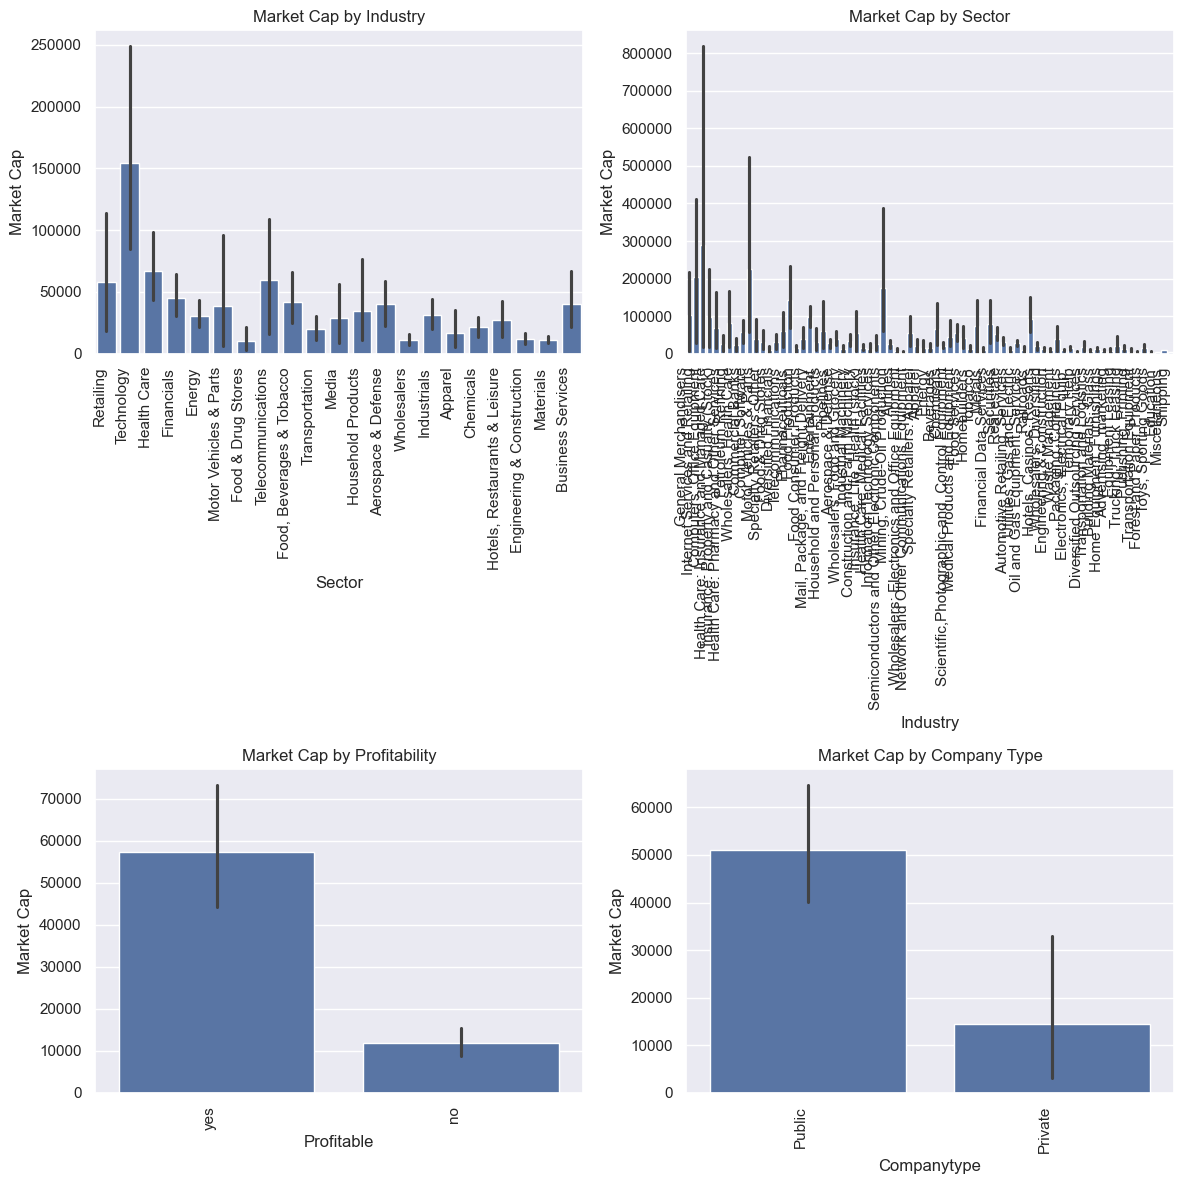

In [832]:
categorical_variables = ["Sector", "Industry", "Profitable", "CompanyType"]


fig, ax = plt.subplots(2, 2, figsize=(12, 12))

subplot_titles = {
    "Market Cap by Sector", 
    "Market Cap by Industry", 
    "Market Cap by Profitability",
    "Market Cap by Company Type",

}

for var, title, subplot in zip(categorical_variables, subplot_titles, ax.flatten()):
    sns.barplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    subplot.set_xlabel(var.capitalize())
    subplot.set_ylabel("Market Cap")
    subplot.set_title(title)
    plt.setp(subplot.xaxis.get_majorticklabels(), rotation=90, ha="right")

plt.tight_layout()
plt.show()

**1.3 Compare the Market Cap by Revenue and EBITDA. Create a Scatter plot for Revenue vs Market Cap categorized by Profitability.**

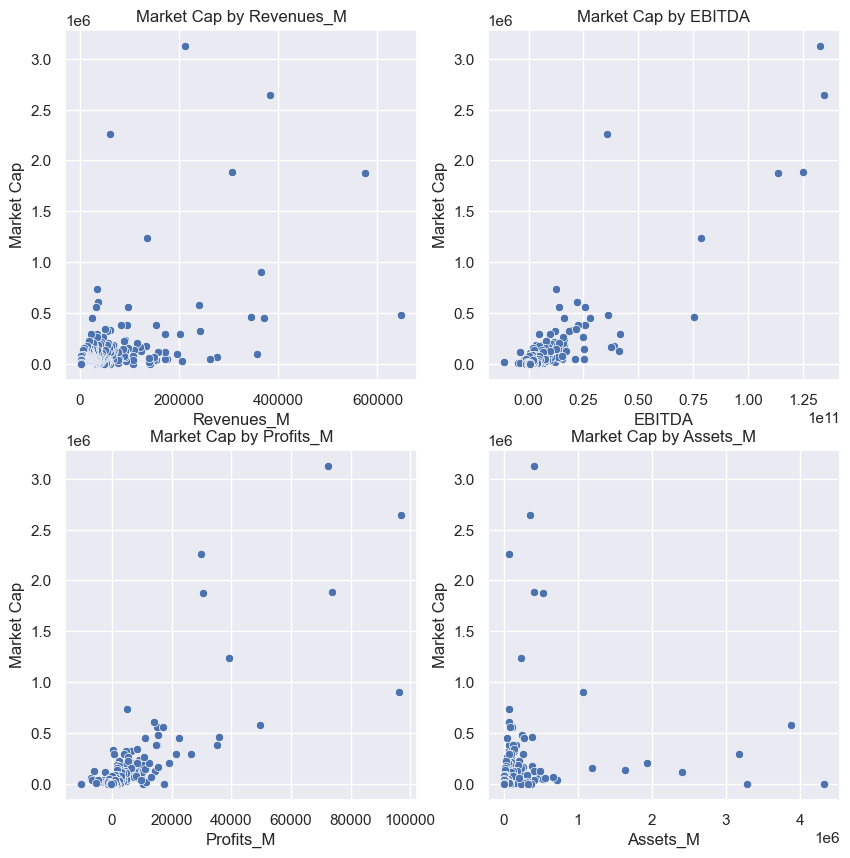

In [833]:
# Plot scatter plots for numerical features vs. Market Cap
num_features = ["Revenues_M", "EBITDA", "Profits_M", "Assets_M"]

fig, ax = plt.subplots(2,2, figsize=(10,10))

for var, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    
    # Labels
    subplot.set_xlabel(var)
    subplot.set_ylabel("Market Cap")
    subplot.set_title(f"Market Cap by {var}")

plt.show()

### **Part 2: Data Preprocessing**

Before we can fit a linear regression model, several pre-processing steps should be applied to the dataset:
 
1. **Encode categorical features appropriately** (e.g., `Sector`, `Industry`, `CompanyType`).
2. **Check for multicollinearity** by analyzing the correlation matrix and removing any highly collinear features.
3. **Split the dataset** into training (60%), validation (20%), and test (20%) sets.
4. **Standardize the feature matrices** (`X_train`, `X_val`, and `X_test`) to have zero mean and unit variance.
 

### Multicollinearity

Checking for high correlation is important because linear regression assumes independence, and it is difficult to ascertain a linear relationship between features with multilinearity. Dropping one category of each encoded variable is necessary before proceeding further to avoid collinear columns, which will result in a singular matrix. These matrices are not invertible, and therefore collinear columns affect if we can apply the closed form solution. It is also much easier to train the model after dropping the features with high correlations from the dataframe. 

**2.2 Plot the correlation matrix and drop highly correlated features.**

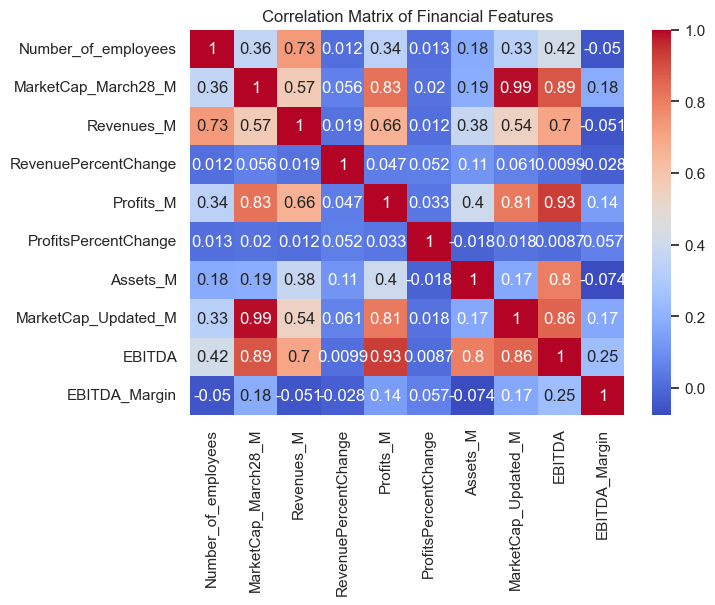

In [834]:
## Create correlation matrix

df_numeric = initial_df.select_dtypes(include=[np.number]) #TODO: make num_features
corr_matrix = df_numeric.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix of Financial Features')
plt.show()

**We will process the data by handling missing data, encoding the categorical variables, and applying standardization.**

We handled missing data by imputing the median. Additionally, in creating the dataset, we impute different values for EBITDA values that are missing (e.g., we imputed the LTM calculation into the cells with missing values). Note: we also dropped "EBITDA" because of its correlation with "EBITDA_Margins", where EBITDA margins were determined to be more important for our objective than the raw EBITDA values. 

In [835]:
# Handle missing values (we use `SimpleImputer()`` to impute the median – especially because of the skewed natre of our data)

imputer = SimpleImputer(strategy='median')
numeric_columns = initial_df.select_dtypes(include=[np.number]).columns
initial_df[numeric_columns] = imputer.fit_transform(initial_df[numeric_columns])

In [836]:
# Encode categorical features
encoded_df = pd.get_dummies(initial_df, columns=["Sector", "Industry", "CompanyType", "Profitable"], drop_first=True)

In [837]:
# Dropping highly correlated features

dropped = ['MarketCap_Updated_M', 'Profits_M', 'Number_of_employees'] 
df = encoded_df.drop(columns=dropped)

**Explanation of feature correlation**

Profits can oftentimes be proportional to Market Cap which explains the correlation between the variables. If a company is generating more profit, investors are more likely to want to invest in the company. These companies that are generating high profits will likely have more investors and consequently higher market cap.

**Cap Outliers for Key Features**

In [838]:
# We have really skewed data 


# Pandas .quantile()
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
upper_limit = df['MarketCap_March28_M'].quantile(0.99)
lower_limit = df['MarketCap_March28_M'].quantile(0.01)

# NumPy clip()
# https://numpy.org/doc/2.1/reference/generated/numpy.clip.html 
df['MarketCap_March28_M'] = np.clip(df['MarketCap_March28_M'], lower_limit, upper_limit)

for col in ['Revenues_M', 'Assets_M', 'EBITDA']:

    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)

    df[col] = np.clip(df[col], lower_limit, upper_limit)

In [839]:
# Prepare data for training

X = df.drop(columns=['MarketCap_March28_M'])  
y = df['MarketCap_March28_M'] 

### Dataset Split

**Split the dataset into training (60%), validation (20%), and test (20%) sets.**

In [840]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Scale the data using `RobustScaler()`**

In [841]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We now have the following vectors and matrices:

- **X_train**: Training set feature matrix.
- **X_val**: Validation set feature matrix.
- **X_test**: Test set feature matrix.
- **y_train**: Training set labels (Market Cap).
- **y_val**: Validation set labels.
- **y_test**: Test set labels.

# II. Regression

We will first train a linear regression model. Financial data is typically imbalanced, and, as we saw in our results above, much of the data is skewed. We will perform Ridge Regression with hyperparameter tuning, and add additional models to analyze results. Lastly, we will evaluate the models. 

### Part 1: **Linear Regression Model**

We will create the model using scikit-learn's `LinearRegression()` and then evaluate the model.

**Evaluate the Linear Regression model**

In [842]:
# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

**Linear Regression Model Evaluation**

In [843]:
# Evaluate the model
train_score = r2_score(y_train, y_train_pred)
val_score = r2_score(y_val, y_val_pred)
test_score = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R² coefficient: {train_score}")
print(f"Validation set R² coefficient: {val_score}")
print(f"Test set R² coefficient: {test_score}")
print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")

Training set R² coefficient: 0.724539548494701
Validation set R² coefficient: 0.6898456714410273
Test set R² coefficient: 0.739052872806991
Training set RMSE: 43457.501934738626
Validation set RMSE: 40949.61972993114
Test set RMSE: 47800.89998550059


**Analyzing Feature Importance**

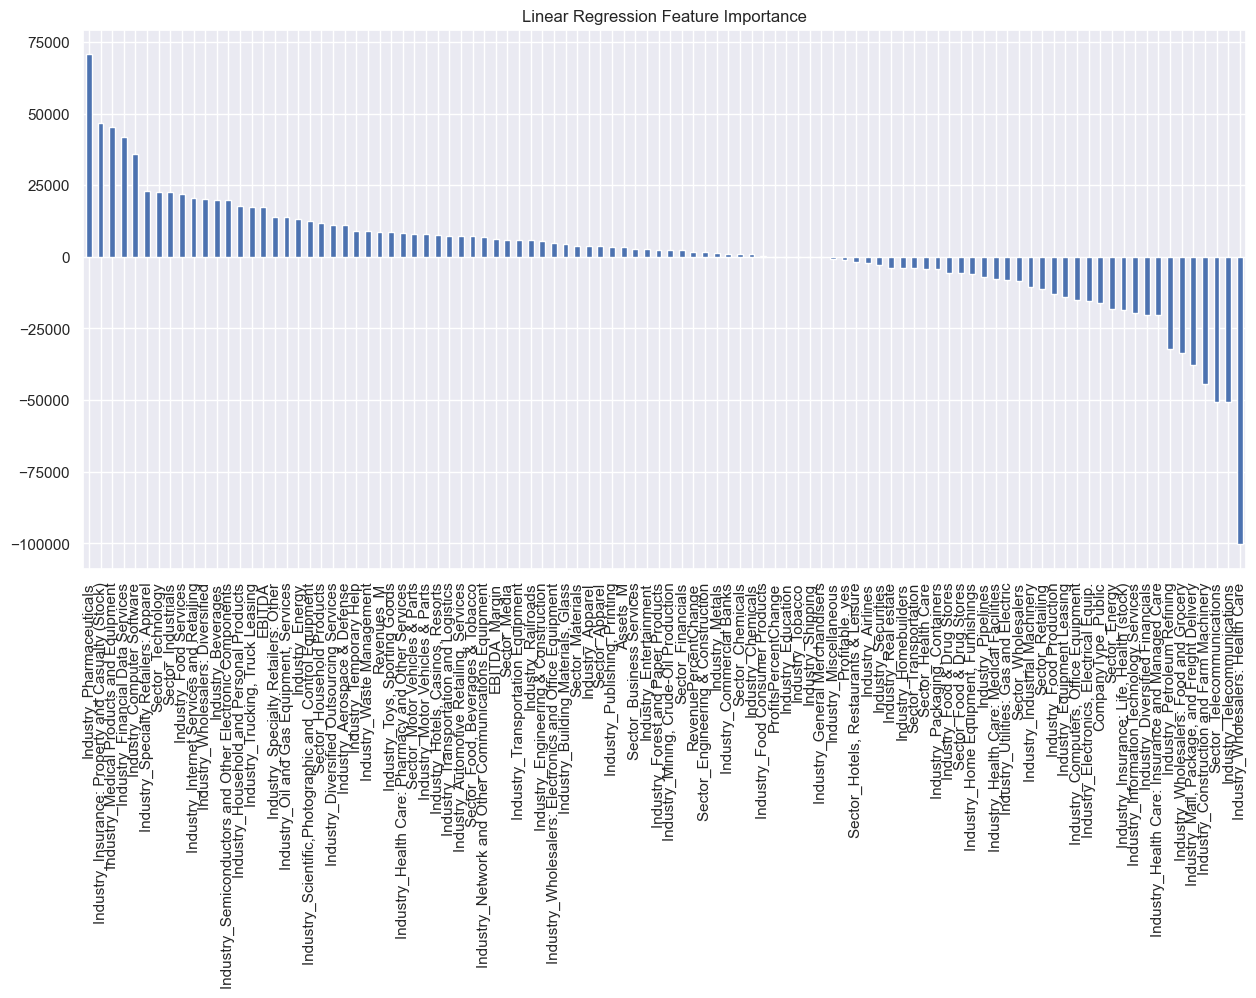

In [844]:
## plot most important features

feature_importance = pd.Series(lr_model.coef_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))

plt.title('Linear Regression Feature Importance')
plt.show()

**Explanation of Feature Importance**

Industry (particularly healthcare-related industries) and certain sectors (e.g., telecommunications) seem to be a significant indication of a company's market cap value. Healthcare tends to grow significantly faster on the basis that pending launches of healthcare drugs will spike market cap severely. 

For instance, during the pandemic, Pfizer's market cap values shot up exponentionally alongside the release of COVID-19-related vaccinations and treatments. As a result, this industry is particularly sensitive to shocks in market cap.

### Part 2: **Ridge Regression**

In [845]:
ridge = Ridge()

**2.1 Grid Search**

In [846]:
alpha_params = np.logspace(-5, 1, 20)
pipe = GridSearchCV(ridge, param_grid={"alpha": alpha_params}, return_train_score=True, cv=5)
pipe.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01])},
             return_train_score=True)

**Find best scores**

In [847]:
best_score = pipe.best_score_
best_alpha = pipe.best_params_
test_score = pipe.score(X_test, y_test)

print(f"Best score: {best_score}")
print(f"Best alpha: {best_alpha}") 
print(f"Test score: {test_score}")

Best score: 0.6073671377548407
Best alpha: {'alpha': np.float64(10.0)}
Test score: 0.7314836614641853


**Model Interpretation.**

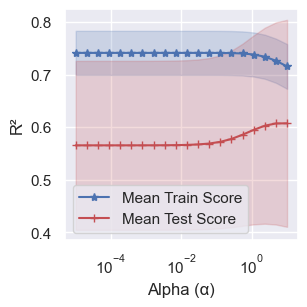

In [848]:
### Plot training and validation R^2 values as a function of alpha
mean_test_score = pipe.cv_results_["mean_test_score"]
std_test_score = pipe.cv_results_["std_test_score"]
mean_train_score = pipe.cv_results_["mean_train_score"]
std_train_score = pipe.cv_results_["std_train_score"]

sns.set()
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1, 1, 1)

# Mean train
plt.plot(alpha_params, mean_train_score, "b*-", label="Mean Train Score")
plt.fill_between(alpha_params, mean_train_score - std_train_score, mean_train_score + std_train_score, color="b", alpha=0.2)

# Mean test
plt.plot(alpha_params, mean_test_score, "r+-", label="Mean Test Score")
plt.fill_between(alpha_params, mean_test_score - std_test_score, mean_test_score + std_test_score, color="r", alpha=0.2)

plt.legend()
ax.set_xscale('log')

# Labels
plt.xlabel("Alpha (α)")
plt.ylabel("R²")

plt.show()

**Updated Ridge Regression model using α=10**

In [849]:
## use best ridge model

best_ridge = Ridge(alpha=10.0)
best_ridge.fit(X_train, y_train)

y_train_pred = best_ridge.predict(X_train)
y_val_pred = best_ridge.predict(X_val)
y_test_pred = best_ridge.predict(X_test)

**RMSE and R² Values**

In [850]:
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R²: {train_r2}")
print(f"Validation set R²: {val_r2}")
print(f"Test set R²: {test_r2}")

print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")


Training set R²: 0.7048563699794093
Validation set R²: 0.7163690509671186
Test set R²: 0.7314836614641853
Training set RMSE: 44983.3544343343
Validation set RMSE: 39159.55598668502
Test set RMSE: 48489.21706160448


# III. Classification

Profitability is one of the more important metrics tied to market capitalization because investors can look for cash flow generation that they assume will be distirbuted to them. Therefore, higher profitability indicates a higher likelihood of dividend distribution that would boost a company's market cap. 

For this reason, we chose **profitability** for our classification task. 